In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

<IPython.core.display.Javascript object>


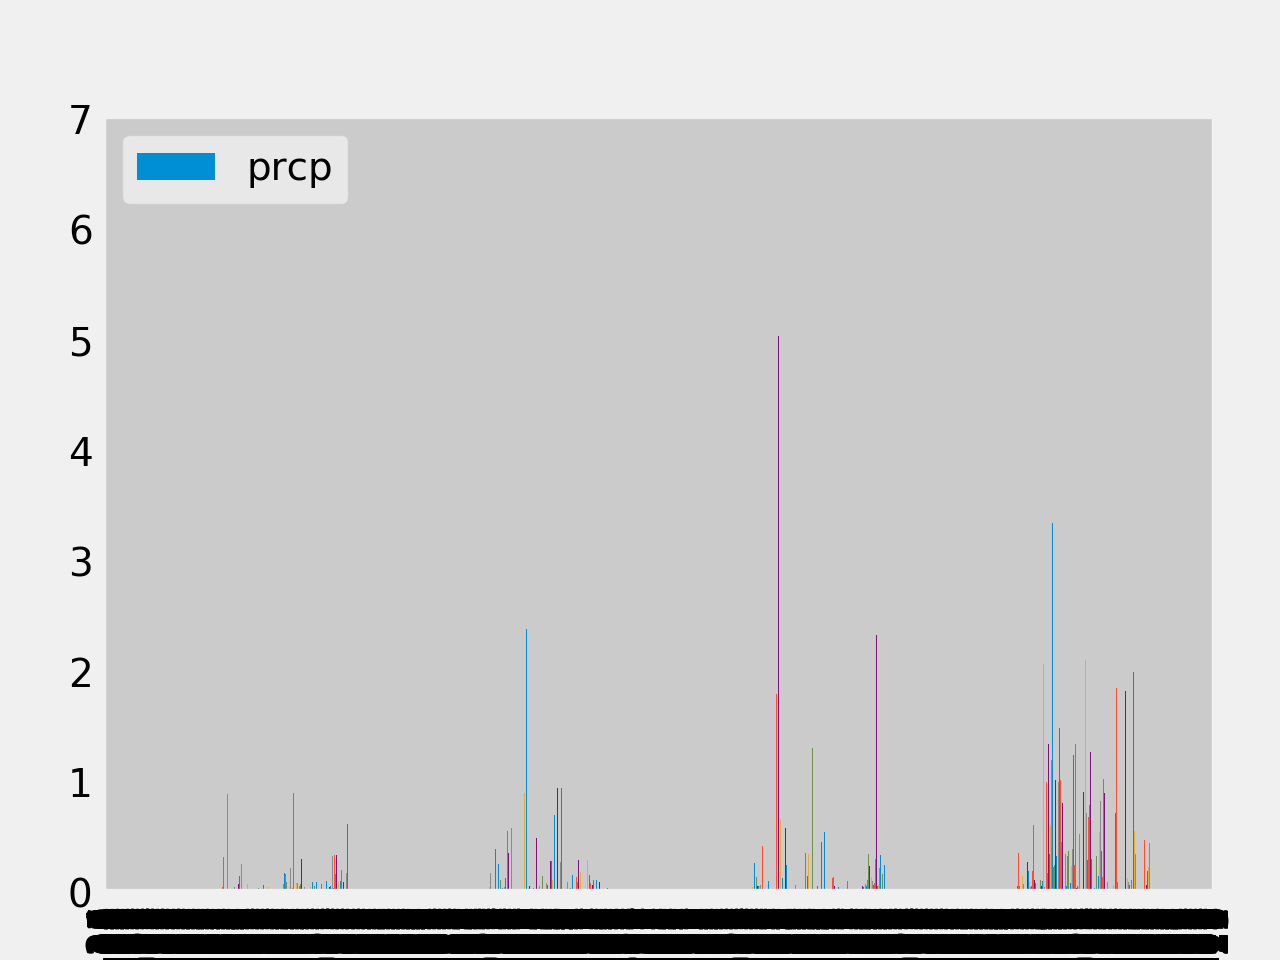

(array([   0,    1,    2, ..., 2220, 2221, 2222]),
 <a list of 2223 Text xticklabel objects>)

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from today (last date in dataset is 8/23/2017)
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
    
# Perform a query to retrieve the data and precipitation scores
rain = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > query_date)
    
# Save the query results as a Pandas DataFrame and set the index to the date column
conn = engine.connect()
rain_pd = pd.read_sql(rain.statement, rain.session.bind)
rain_pd.set_index('date').head()

# Sort the dataframe by date
# SS: IT'S ALREADY SORTED..... ?

# Use Pandas Plotting with Matplotlib to plot the data
bar = rain_pd.plot.bar(x = "date", y='prcp')

# Rotate the xticks for the dates
from datetime import datetime
plt.xticks(rotation=90)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_pd.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [50]:
# How many stations are available in this dataset?
station_count = session.query(Station.station).count()
station_count

9

In [51]:
# What are the most active stations?
# List the stations and the counts in descending order.
measures = session.query(Measurement.station, Measurement.date)
measure_pd = pd.read_sql(measures.statement, measures.session.bind)
measure_pd.groupby('station').count().sort_values(['date'], ascending=False)

,date
station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [52]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
measure_most = session.query(Measurement.tobs).filter(Measurement.station == "USC00519281")
most_pd = pd.read_sql(measure_most.statement, measure_most.session.bind)
low = most_pd.min()
high = most_pd.max()
avg = most_pd.mean()
print(low)
print(high)
print(avg)

tobs    54.0
dtype: float64
tobs    85.0
dtype: float64
tobs    71.663781
dtype: float64


<IPython.core.display.Javascript object>


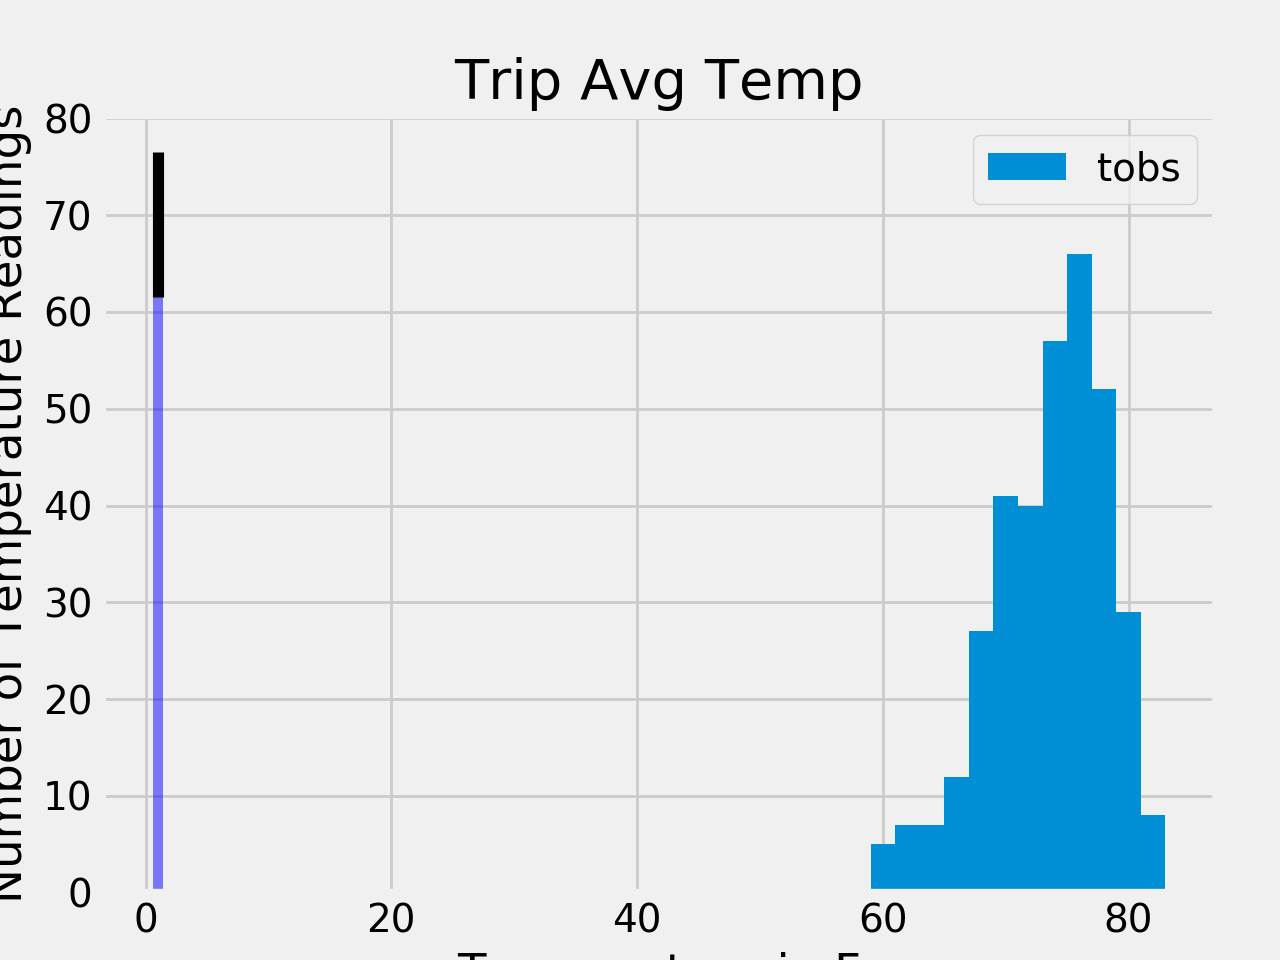

Text(0,0.5,'Number of Temperature Readings')

In [53]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
history = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == "USC00519281").filter(Measurement.date > query_date)
history_pd = pd.read_sql(history.statement, history.session.bind)
hist = history_pd.plot.hist(bins=12)
plt.title("Most Common Temperature Readings")
plt.xlabel("Temperature in F")
plt.ylabel("Number of Temperature Readings")
#plt.show()

In [16]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-09', '2012-02-17'))

[(56.0, 68.98630136986301, 78.0)]


In [54]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-09', '2011-02-17'))

NameError: name 'calc_temps' is not defined

In [55]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.date >= '2012-02-09').filter(Measurement.date <= '2012-02-17').all()
x = 1
yerr_value = 7.5
trip_avg[0]

plt.bar(x, trip_avg[0], color='b', alpha=0.5, align="center", yerr = yerr_value)
plt.title("Trip Avg Temp")
plt.xlabel("Temperature in F")

Text(0.5,8.36667,'Temperature in F')

In [56]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Measurement.tobs).filter(Measurement.date >= "2012-02-09").filter(Measurement.date <= '2012-02-17')
rainfall_pd = pd.read_sql(rainfall.statement, rainfall.session.bind)
rainfall2_pd = rainfall_pd.groupby('station').sum().sort_values(['tobs'], ascending=False)
rainfall2_pd.head()

stat_info = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
stat_info_pd = pd.read_sql(stat_info.statement, stat_info.session.bind)

combined_data = pd.merge(rainfall2_pd, stat_info_pd, on="station", how="inner")
combined_data

,station,tobs,name,latitude,longitude,elevation
0,USC00519523,639.0,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,USC00519397,625.0,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00513117,623.0,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00516128,619.0,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00519281,608.0,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
5,USC00511918,588.0,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
6,USC00514830,551.0,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
7,USC00517948,494.0,"PEARL CITY, HI US",21.39340,-157.97510,11.9
8,USC00518838,289.0,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
